# Create an ensemble DTM of the world at 30m

Within the [Open-Earth-Monitor Cyberinfratructure project](https://earthmonitor.org/), funced by the European Union's Horizon Europe research an innovation programme under grant agreement No. 101059548, we have produced an Ensemble Digital Terrain Model in worldwide coverage. The ensemble model is mainly based on the four publicly available Digital Surface Models: `MERITDEM`, `AW3D30`, `GLO-30`, and three national/continental DTMs: `Europe DTM`, `Australia DTM`, and `USA DTM`. 

Every map first reprojects to `EPSG:4326`, and crop to `(-180.0000000, -62.0005556 180.0000000,  83.8325000)`. For MERITDEM, we downscaled the map into 30m resolution before all the processes above. 

The ensemble map is basically a lower 10% quantile among the maps, and with a map of uncertainty calculated by the standard deviation of maps. 

In addition, we leverage the canopy height map from UMD GLAD, and standard deviation among maps to remove objects on the surface of the Earth including buildings, infrastructure and vegetation in `AW3D30` and `GLO-30`.  If the canopy height exceeds `2 metres` and/or standard deviation exceeds `6 metres`, the pixels would be removed. In the uncertainty map, if there is only one map containing the value of a pixel, the standard deviation would be defined as `-1`. 

In [1]:
import rasterio
from rasterio.windows import Window
from eumap import plotter
from rasterio.windows import from_bounds, bounds,crop
import numpy as np
from eumap.parallel import TilingProcessing
import geopandas as gpd
import pyproj
import bottleneck as bn
import geopandas as gpd
import random
import os
from pathlib import Path
import pandas as pd
import sys
from typing import List
import multiprocessing
from eumap.raster import read_rasters, save_rasters, write_new_raster
from eumap import parallel
from eumap.raster import ttprint
from minio import Minio
import bottleneck as bn

import gc
import traceback
import requests

import warnings
warnings.filterwarnings("ignore")

In [2]:
def _zvalueFromIndex(arr, ind):
    # get number of columns and rows
    _,nC,nR = arr.shape

    # get linear indices and extract elements with np.take()
    idx = nC*nR*ind + np.arange(nC*nR).reshape((nC,nR))
    return np.take(arr, idx)
def nan_percentile(
  arr:np.array,
  q = [25, 50, 75],
  keep_original_vals=False
):

    if keep_original_vals:
        arr = np.copy(arr)
    
    nanall = np.all(np.isnan(arr), axis=0)
    res_shape = (len(q), arr.shape[1], arr.shape[2])
    nanall = np.broadcast_to(nanall, shape=res_shape)
    
    # valid (non NaN) observations along the first axis
    valid_obs = np.sum(np.isfinite(arr), axis=0)
    
    # replace NaN with maximum
    max_val = np.nanmax(arr)
    arr[np.isnan(arr)] = max_val
    
    # sort - former NaNs will move to the end
    arr = np.sort(arr, axis=0)
    
    # loop over requested quantiles
    if type(q) is list:
        qs = []
        qs.extend(q)
    else:
        qs = [q]
    if len(qs) <= 2:
        quant_arr = np.zeros(shape=(arr.shape[1], arr.shape[2]))
    else:
        quant_arr = np.zeros(shape=(len(qs), arr.shape[1], arr.shape[2]))
    
    result = []
    for i in range(len(qs)):
        quant = qs[i]
        # desired position as well as floor and ceiling of it
        k_arr = (valid_obs - 1) * (quant / 100.0)
        f_arr = np.floor(k_arr).astype(np.int32)
        c_arr = np.ceil(k_arr).astype(np.int32)
        fc_equal_k_mask = f_arr == c_arr
    
        # linear interpolation (like numpy percentile) takes the fractional part of desired position
        floor_val = _zvalueFromIndex(arr=arr, ind=f_arr) * (c_arr - k_arr)
        ceil_val = _zvalueFromIndex(arr=arr, ind=c_arr) * (k_arr - f_arr)
    
        quant_arr = floor_val + ceil_val
        quant_arr[fc_equal_k_mask] = _zvalueFromIndex(arr=arr, ind=k_arr.astype(np.int32))[fc_equal_k_mask]  # if floor == ceiling take floor value
    
        result.append(quant_arr)
    
    result = np.stack(result, axis=0).astype('float32')
    result[nanall] = np.nan
    
    return result

## Small region test

you can test things in a small area, if you know the coordinates and the Coordinate reference system(CRS) in EPSG:xxxx according to it

In [3]:
# boschord
crs_origin = 28992
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (208310,543070,213860,548470)

In [ ]:
# calabria
crs_origin = 32633
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (613323,4413526,617373,4417451)

In [ ]:
# fishcamp
crs_origin = 26911
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (268012,4149012,269987,4149987)

In [ ]:
# coast
crs_origin = 4326
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (31.959101,62.694486,32.159101,62.894486)

In [ ]:
# australian island
crs_origin = 28354
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (413154,5940894,433154,5959894)

In [ ]:
# gabon
crs_origin = 4326
xmin_ori,ymin_ori,xmax_ori,ymax_ori = (11.1079,0.3873,11.3079,0.5873)

## Crop and take a look of the input data

In [4]:
raster_files = [
    'http://192.168.1.30:8333/tmp-dtm/GLO30_30m_v01272022.tif',
    'http://192.168.1.30:8333/tmp-dtm/dtm_elevation_aw3d30.dsm_m_30m_s0..0cm_2018_af_equi7_v01202022.tif',
    'http://192.168.1.30:8333/tmp-dtm/merit_30m_v01262022.tif',
    'http://192.168.1.30:8333/tmp-dtm/canopy.height_glad.umd_m_30m_s_2017_2018_go_epsg.4326_v01242022.tif',
    'http://192.168.1.30:8333/tmp-dtm/surface.water_jrc.gswe_p_30m_s_2000_2018_go_epsg.4326_v01232022.tif',
    'http://192.168.1.30:8333/tmp-dtm/dtm_elev.lowestmode_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg4326_vDTMensemble_dm_v2.tif',
    'http://192.168.1.30:8333/tmp-dtm/dtm_elevation_usgs.dsm_m_30m_s0..0cm_2021_usa48_DTMensemble_epsg4326.tif',
    'http://192.168.1.30:8333/tmp-dtm/aus_espg4326.tif'
]

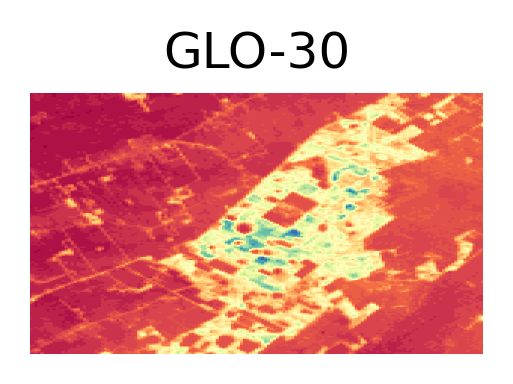

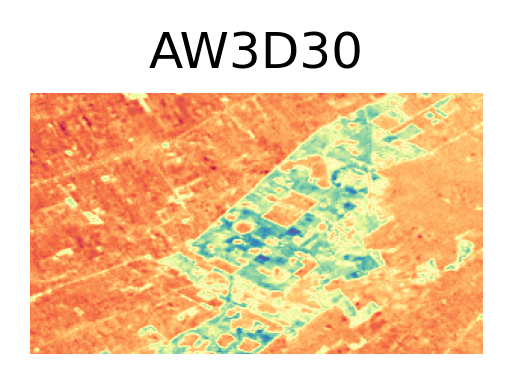

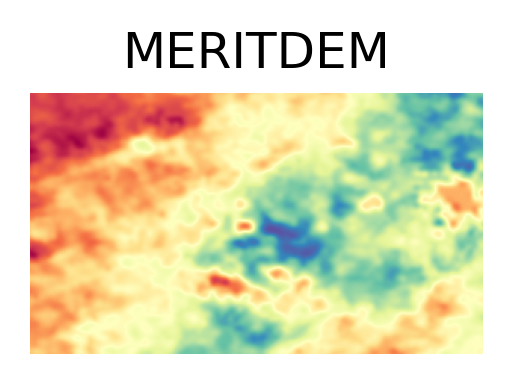

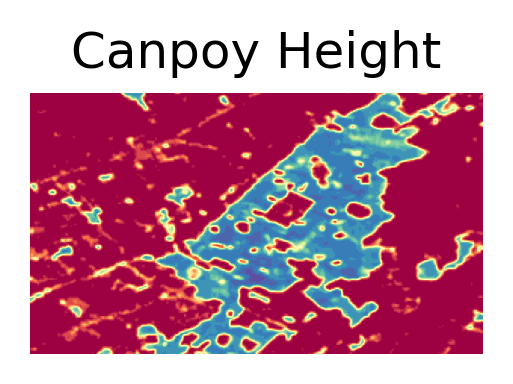

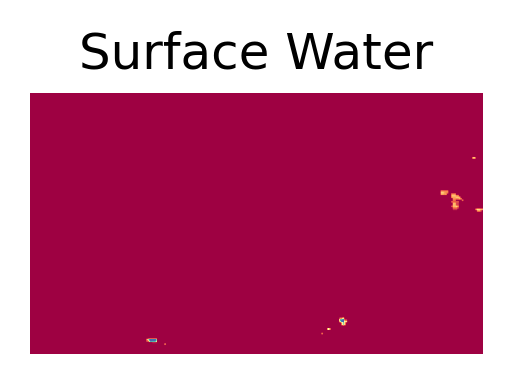

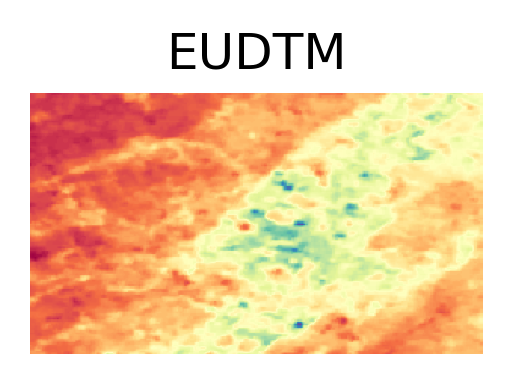

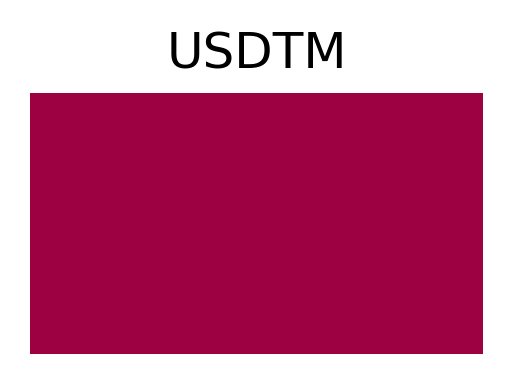

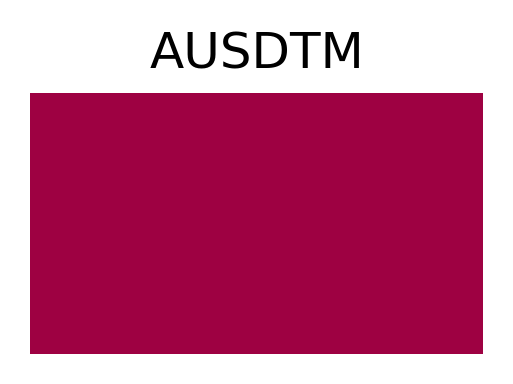

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

data = []
title_list = ['GLO-30','AW3D30','MERITDEM','Canpoy Height','Surface Water','EUDTM','USDTM','AUSDTM']
for i,file in enumerate(raster_files):
    title = title_list[i]
    src = rasterio.open(file)
    transform = src.transform
    crs = src.crs
    proj = pyproj.Transformer.from_crs(crs_origin, crs, always_xy=True)
    xmin, ymin = proj.transform(xmin_ori,ymin_ori)
    xmax, ymax = proj.transform(xmax_ori,ymax_ori)
    try:
        window = rasterio.windows.from_bounds(left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform)
        window = window.round_lengths(pixel_precision=0)
        plotter.plot_rasters(
            src.read(1, window=window),
            titles=title,
            dpi = 300,
            figsize=2,
            #out_file = f'{title}.png'
        )
        data.append(src.read(1, window=window).astype(np.float32))
    except:
        print(f'{file} no data')

In [6]:
GLO  = data[0]
ALOS = data[1]
merit= data[2]
canpoy_height = data[3]
surf = data[4]
NDTM_eu = data[5]
NDTM_us = data[6]
NDTM_aus = data[7]

In [7]:
# Define the nodata value to nan in python
GLO[GLO==-32767.]=None
merit[merit==-9999]=None
canpoy_height[canpoy_height==101]=None
NDTM_eu[NDTM_eu==-9999]=None
NDTM_us[NDTM_us==-9999]=None
NDTM_aus[NDTM_aus==-9999]=None

In [8]:
# transfrom measurement from metre(m) to decimetre(dm)
GLO = GLO*10
merit = merit*10
NDTM_us = NDTM_us * 10
NDTM_aus = NDTM_aus * 10

In [9]:
# mask ALOs ocean data
dec_map = np.dstack((np.isnan(GLO),np.isnan(merit),np.isnan(NDTM_eu),np.isnan(NDTM_us),np.isnan(NDTM_aus)))
ocean_mask = np.all(dec_map,axis=2)

ALOS[ocean_mask]=None
ALOS = ALOS*10

In [10]:
# masked the high variation region and canpoy in GLO and ALOS
dtm = np.dstack((GLO,ALOS,merit,NDTM_eu,NDTM_us,NDTM_aus))
dtm_sd = bn.nanstd(dtm,axis=2)
GLO[dtm_sd>60] = None
ALOS[dtm_sd>60] = None
GLO[canpoy_height > 2 ] = None
ALOS[canpoy_height > 2 ] = None

In [11]:
# Calculate bare earth and standard deviation among the input maps

bare_data = np.dstack((GLO,ALOS,merit,NDTM_eu,NDTM_us,NDTM_aus))
valid_pixel = np.count_nonzero(~np.isnan(bare_data),axis=2)>=2

bare_earth_sd = bn.nanstd(bare_data,axis=2)
bare_earth = nan_percentile(bare_data.transpose(2,0,1),q=[10])[0]
bare_earth[~valid_pixel] = merit[~valid_pixel]
bare_earth_sd[~valid_pixel] = -1
output_data = np.dstack((bare_earth,bare_earth_sd))

## Plot the test result!

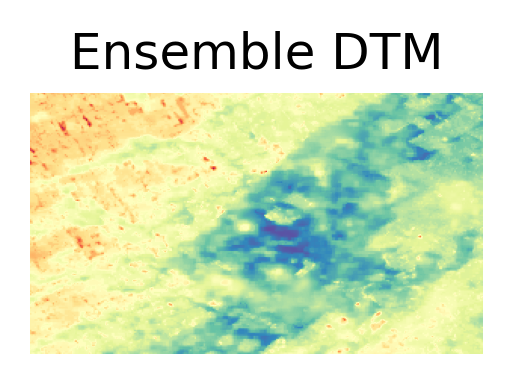

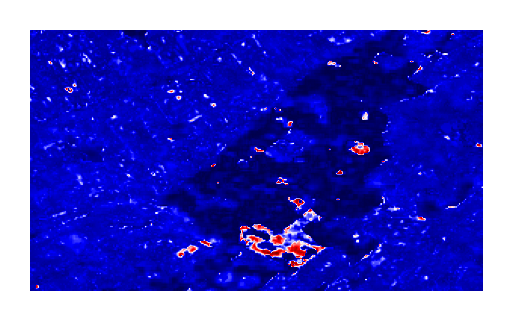

In [12]:
plotter.plot_rasters(
    bare_earth,
    titles='Ensemble DTM',
    dpi = 300,
    figsize=2,
    #out_file = 'Ensemble DTM.png'
)

plotter.plot_rasters(
    bare_earth_sd,
    dpi = 300,
    figsize=2,
    cmaps = 'seismic',
    #out_file = 'Ensemble DTM std.png'
)